In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# PREPROCESSING

Read IBM stock OHLC ( open, high, low, close) and S&P 500 bid/ask data. data into pandas dataframe.

In [2]:
stock=pd.read_csv('삼성전자주가(20220406-20240405).csv')
df=stock.copy()

In [3]:
df["Datetime"] = pd.to_datetime(df["Datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

In [4]:
'''
df.drop('2022-04-06 09:00:00', axis=0, inplace=True)
for i in range(len(df)):
    if i==len(df)-1:
        break
    df.iloc[len(df)-i-1, :]=df.iloc[len(df)-i-1, :]/df.iloc[len(df)-i-2,:]-1
scale_value=df.iloc[0,:]
df.drop('2022-04-06 10:00:00', axis=0, inplace=True)
'''

"\ndf.drop('2022-04-06 09:00:00', axis=0, inplace=True)\nfor i in range(len(df)):\n    if i==len(df)-1:\n        break\n    df.iloc[len(df)-i-1, :]=df.iloc[len(df)-i-1, :]/df.iloc[len(df)-i-2,:]-1\nscale_value=df.iloc[0,:]\ndf.drop('2022-04-06 10:00:00', axis=0, inplace=True)\n"

In [207]:
df

,Open,High,Low,Close,Adj Close,Volume,change,target
Datetime,,,,,,,,
2022-04-06 09:00:00,68600.0,68800.0,68600.0,68700.0,68700.0,0,0,0
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,68700.0,1846582,0,0
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,68600.0,901392,-100,-1
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,68600.0,2053045,0,0
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,68600.0,924688,0,0
...,...,...,...,...,...,...,...,...
2024-04-05 10:00:00,84700.0,84800.0,83800.0,84000.0,84000.0,3548675,-700,-1
2024-04-05 11:00:00,83900.0,84300.0,83900.0,84200.0,84200.0,1732644,200,1
2024-04-05 12:00:00,84300.0,84500.0,84100.0,84400.0,84400.0,1052082,200,1


In [20]:
df['change']=0
df['target']=0
for i in range(len(df)-1):
    df.iloc[i+1,6]=df.iloc[i+1,3]-df.iloc[i,3]
df.loc[df['change']==0, 'target']=0
df.loc[df['change']<0, 'target']=-1
df.loc[df['change']>0, 'target']=1

In [309]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 데이터 로드 및 선택

features = df[['Open', 'High', 'Low', 'change', 'Volume', 'Close']].values

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, 3]  # 종가(Close)를 예측값으로 설정
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 시퀀스 데이터 생성
seq_len = 30  # 시퀀스 길이 설정

train_size = int(len(scaled_features) * 0.7)
val_size = int(len(scaled_features) * 0.2)
test_size = len(scaled_features) - train_size - val_size

# 시퀀스 생성을 고려한 인덱스
end_train = train_size - seq_len
end_val = train_size + val_size - seq_len

X_train, y_train = create_sequences(scaled_features[:train_size], seq_len)
X_val, y_val = create_sequences(scaled_features[train_size:train_size+val_size], seq_len)
X_test, y_test = create_sequences(scaled_features[train_size+val_size:], seq_len)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoader 설정
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=False)

val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(dataset=val_data, batch_size=16, shuffle=False)

test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_data, batch_size=16, shuffle=False)

# 모델 설정 변경
# 일단은 통합적으로 생성
class configs:
    seq_len = 2
    pred_len = 1
    enc_in = 6  # 입력 채널을 5로 변경 (시가, 고가, 저가, 종가, 거래량)
    individual = False

In [310]:
from transformers import PatchTSTConfig, PatchTSTForPrediction

configuration = PatchTSTConfig(prediction_length=1, context_length=seq_len, num_input_channels=6, drop_out=0.3)

model = PatchTSTForPrediction(configuration)

configuration = model.config

In [311]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [312]:
import torch.optim as optim

patience = 25  # 검증 손실이 개선되지 않는 에포크 허용 횟수
min_delta = 0.00001  # 개선으로 간주되기 위한 최소 변화량
best_loss = np.inf  # 가장 낮은 검증 손실을 추적dd
last_val_loss = np.inf
patience_counter = 0  # 개선되지 않는 에포크를 세는 카운터

# 손실 함수와 최적화 알고리즘 설정
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)



# 학습 과정
epochs = 100

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()  # 모델을 훈련 모드로 설정
    train_loss = 0.0

    for seqs, labels in train_loader:
        optimizer.zero_grad()  # 그래디언트 초기화
        outputs = model(
            past_values=seqs
        )
        loss = criterion(outputs.prediction_outputs[:,:,3], labels)
        loss.backward()
        optimizer.step()  # 최적화 알고리즘을 통한 파라미터 업데이트
        
        train_loss += loss.item() * seqs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0

    with torch.no_grad():
        model.eval()
        for seqs, labels in val_loader:
            outputs = model(
                past_values=seqs
            )
            loss = criterion(outputs.prediction_outputs[:,:,3], labels)
            val_loss += loss.item() * seqs.size(0)  # 누적 손실 계산

    # 에포크별 평균 검증 손실 계산
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')

    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'Early Stopping Counter {patience_counter} of {patience}')

    last_val_loss = val_loss  # 마지막 검증 손실 업데이트

    if patience_counter >= patience:
        print("Early stopping initiated.")
        print(f"Best Validation Loss: {best_loss:.5f}")
        break

C:\Users\horri\anaconda3\envs\nlp\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\horri\anaconda3\envs\nlp\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\horri\anaconda3\envs\nlp\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the sam

Epoch 1/100, Train Loss: 0.07192, Val Loss: 0.06776
Epoch 2/100, Train Loss: 0.07172, Val Loss: 0.06838
Early Stopping Counter 1 of 25
Epoch 3/100, Train Loss: 0.07163, Val Loss: 0.06746
Epoch 4/100, Train Loss: 0.07153, Val Loss: 0.06743
Epoch 5/100, Train Loss: 0.07156, Val Loss: 0.06717
Epoch 6/100, Train Loss: 0.07153, Val Loss: 0.06750
Early Stopping Counter 1 of 25
Epoch 7/100, Train Loss: 0.07153, Val Loss: 0.06708
Epoch 8/100, Train Loss: 0.07151, Val Loss: 0.06726
Early Stopping Counter 1 of 25
Epoch 9/100, Train Loss: 0.07147, Val Loss: 0.06729
Early Stopping Counter 2 of 25
Epoch 10/100, Train Loss: 0.07147, Val Loss: 0.06715
Early Stopping Counter 3 of 25
Epoch 11/100, Train Loss: 0.07144, Val Loss: 0.06710
Early Stopping Counter 4 of 25
Epoch 12/100, Train Loss: 0.07146, Val Loss: 0.06732
Early Stopping Counter 5 of 25
Epoch 13/100, Train Loss: 0.07142, Val Loss: 0.06700
Epoch 14/100, Train Loss: 0.07141, Val Loss: 0.06700
Early Stopping Counter 1 of 25
Epoch 15/100, Train

In [ ]:
'''
import itertools

# 실험할 하이퍼파라미터 조합 정의
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
hidden_sizes = [64, 128, 256]
seq_len = [6, 12, 24, 48]
drop_out=[0.1, 0.2, 0.5]

# 가능한 모든 하이퍼파라미터 조합 생성
hyperparameter_combinations = list(itertools.product(learning_rates, batch_sizes, hidden_sizes, seq_len))

best_val_loss = np.inf
best_hyperparameters = None

# 각 하이퍼파라미터 조합에 대해 그리드 서치 실행
for lr, batch_size, hidden_size, seq_len in hyperparameter_combinations:

    # DataLoader 설정
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)

    val_data = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

    # 모델 설정 변경
    # 일단은 통합적으로 생성
    class configs:
        seq_len = seq_len
        pred_len = 1
        enc_in = 6  # 입력 채널을 5로 변경 (시가, 고가, 저가, 종가, 거래량)
        individual = False
    
    # 모델 생성
    configuration = PatchTSTConfig(prediction_length=1, context_length=seq_len, num_input_channels=6, drop_out=drop_out, hidden_size=hidden_size)

    model = PatchTSTForPrediction(configuration)
    
    # 모델 학습 및 검증
    patience = 25  # 검증 손실이 개선되지 않는 에포크 허용 횟수
    min_delta = 0.00001  # 개선으로 간주되기 위한 최소 변화량
    best_loss = np.inf  # 가장 낮은 검증 손실을 추적dd
    last_val_loss = np.inf
    patience_counter = 0  # 개선되지 않는 에포크를 세는 카운터

    # 손실 함수와 최적화 알고리즘 설정
    criterion = RMSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)



    # 학습 과정
    epochs = 100

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # 모델을 훈련 모드로 설정
        train_loss = 0.0

        for seqs, labels in train_loader:
            optimizer.zero_grad()  # 그래디언트 초기화
            outputs = model(
                past_values=seqs
            )
            loss = criterion(outputs.prediction_outputs[:,:,3], labels)
            loss.backward()
            optimizer.step()  # 최적화 알고리즘을 통한 파라미터 업데이트

            train_loss += loss.item() * seqs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()  # 모델을 평가 모드로 설정
        val_loss = 0.0

        with torch.no_grad():
            model.eval()
            for seqs, labels in val_loader:
                outputs = model(
                    past_values=seqs
                )
                loss = criterion(outputs.prediction_outputs[:,:,3], labels)
                val_loss += loss.item() * seqs.size(0)  # 누적 손실 계산

        # 에포크별 평균 검증 손실 계산
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')

        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'Early Stopping Counter {patience_counter} of {patience}')

        last_val_loss = val_loss  # 마지막 검증 손실 업데이트

        if patience_counter >= patience:
            print("Early stopping initiated.")
            print(f"Best Validation Loss: {best_loss:.5f}")
            break
    
    # 검증 성능 평가
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparameters = (lr, batch_size, hidden_size)

print("Best Validation Loss:", best_val_loss)
print("Best Hyperparameters:", best_hyperparameters)
'''

In [290]:
#model2=model

In [291]:
#model1=model

In [292]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB, modelC, output):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC

    def forward(self,x):
        out1 = self.modelA(x)
        out2 = self.modelB(x)
        out3 = self.modelC(x)

        out = out1.prediction_outputs + out2.prediction_outputs + out3.prediction_outputs
        x = out/3
        return x

In [293]:
#model=MyEnsemble(model1, model2, model2, 1)

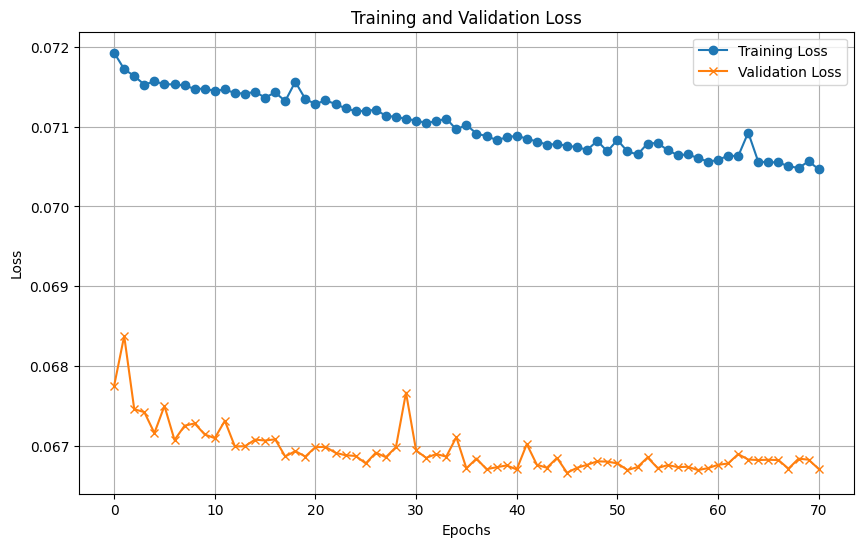

In [313]:
import matplotlib.pyplot as plt

# 위에 제시된 훈련 및 검증 과정 코드 실행 후 실행

# 훈련 손실과 검증 손실을 에포크별로 그래프로 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.plot(train_losses, label='Training Loss', marker='o')  # 훈련 손실 그래프
plt.plot(val_losses, label='Validation Loss', marker='x')  # 검증 손실 그래프
plt.title('Training and Validation Loss')  # 그래프 제목
plt.xlabel('Epochs')  # x축 라벨
plt.ylabel('Loss')  # y축 라벨
plt.legend()  # 범례 표시
plt.grid(True)  # 그리드 표시
plt.show()  # 그래프 보여주기

In [314]:
# 테스트 데이터셋에 대한 평가 및 결과 출력

model.eval()  # 모델을 평가 모드로 설정
test_losses = []  # 테스트 손실을 저장할 리스트
predictions = []  # 예측값을 저장할 리스트
actuals = []  # 실제값을 저장할 리스트

with torch.no_grad():  # 기울기 계산을 비활성화
    for seqs, labels in test_loader:

        outputs = model(seqs)

        # 손실 계산
        loss = criterion(outputs.prediction_outputs[:,:,3], labels)
        #loss = criterion(outputs.prediction_logits.argmax(axis=1).reshape(-1,1), labels*2)
        test_losses.append(loss.item())

        # 예측값과 실제값 저장
        predictions.extend(outputs.prediction_outputs[:,:,3].view(-1).detach().numpy())
        #predictions.extend(outputs.prediction_logits.argmax(axis=1).detach().numpy())
        actuals.extend(labels.view(-1).detach().numpy())

# 평균 테스트 손실 계산 및 출력
average_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {average_test_loss}')

predictions_temp = np.zeros((len(predictions), 6))  # 6는 특성의 총 개수입니다.
predictions_temp[:, 3] = predictions  # 종가 위치에 예측값 할당

actuals_temp = np.zeros((len(actuals), 6))  # 실제 데이터를 위한 동일한 접근 방식
actuals_temp[:, 3] = actuals  # 종가 위치에 실제값 할당


# 예측값과 실제값 출력 (처음 10개 샘플)
yest=np.delete(np.insert(scaler.inverse_transform(X_test[:,-1,:])[:,-1], 0, 0), -1)
predictions_inverse = np.round(scaler.inverse_transform(predictions_temp)[:,3], -2)+yest
actuals_inverse = np.round(scaler.inverse_transform(actuals_temp)[:,3], -2)+yest


# 역정규화된 예측값과 실제값 출력 (처음 10개 샘플)
print("Predictions vs. Actuals (First 10 Samples, After Inverse Scaling):")
for i in range(10):
    print(f'Prediction: {predictions_inverse[i]:.4f}, Actual: {actuals_inverse[i]:.4f}')

Average Test Loss: 0.08295762977179359
Predictions vs. Actuals (First 10 Samples, After Inverse Scaling):
Prediction: 0.0000, Actual: -300.0000
Prediction: 73200.0000, Actual: 72900.0000
Prediction: 72900.0000, Actual: 74300.0000
Prediction: 72600.0000, Actual: 72200.0000
Prediction: 73900.0000, Actual: 74200.0000
Prediction: 73600.0000, Actual: 73200.0000
Prediction: 73700.0000, Actual: 73500.0000
Prediction: 73300.0000, Actual: 73400.0000
Prediction: 73000.0000, Actual: 74800.0000
Prediction: 73100.0000, Actual: 73100.0000


In [315]:
predictions_inverse=predictions_inverse[1:]
actuals_inverse=actuals_inverse[1:]

In [316]:
differences = [abs(pred - actual) for pred, actual in zip(predictions_inverse, actuals_inverse)]

In [317]:
print("최대 : " , max(differences) ,"최소 : " , min(differences) ,"평균: " , sum(differences) / len(differences))

최대 :  2400.0 최소 :  0.0 평균:  283.0188679245283


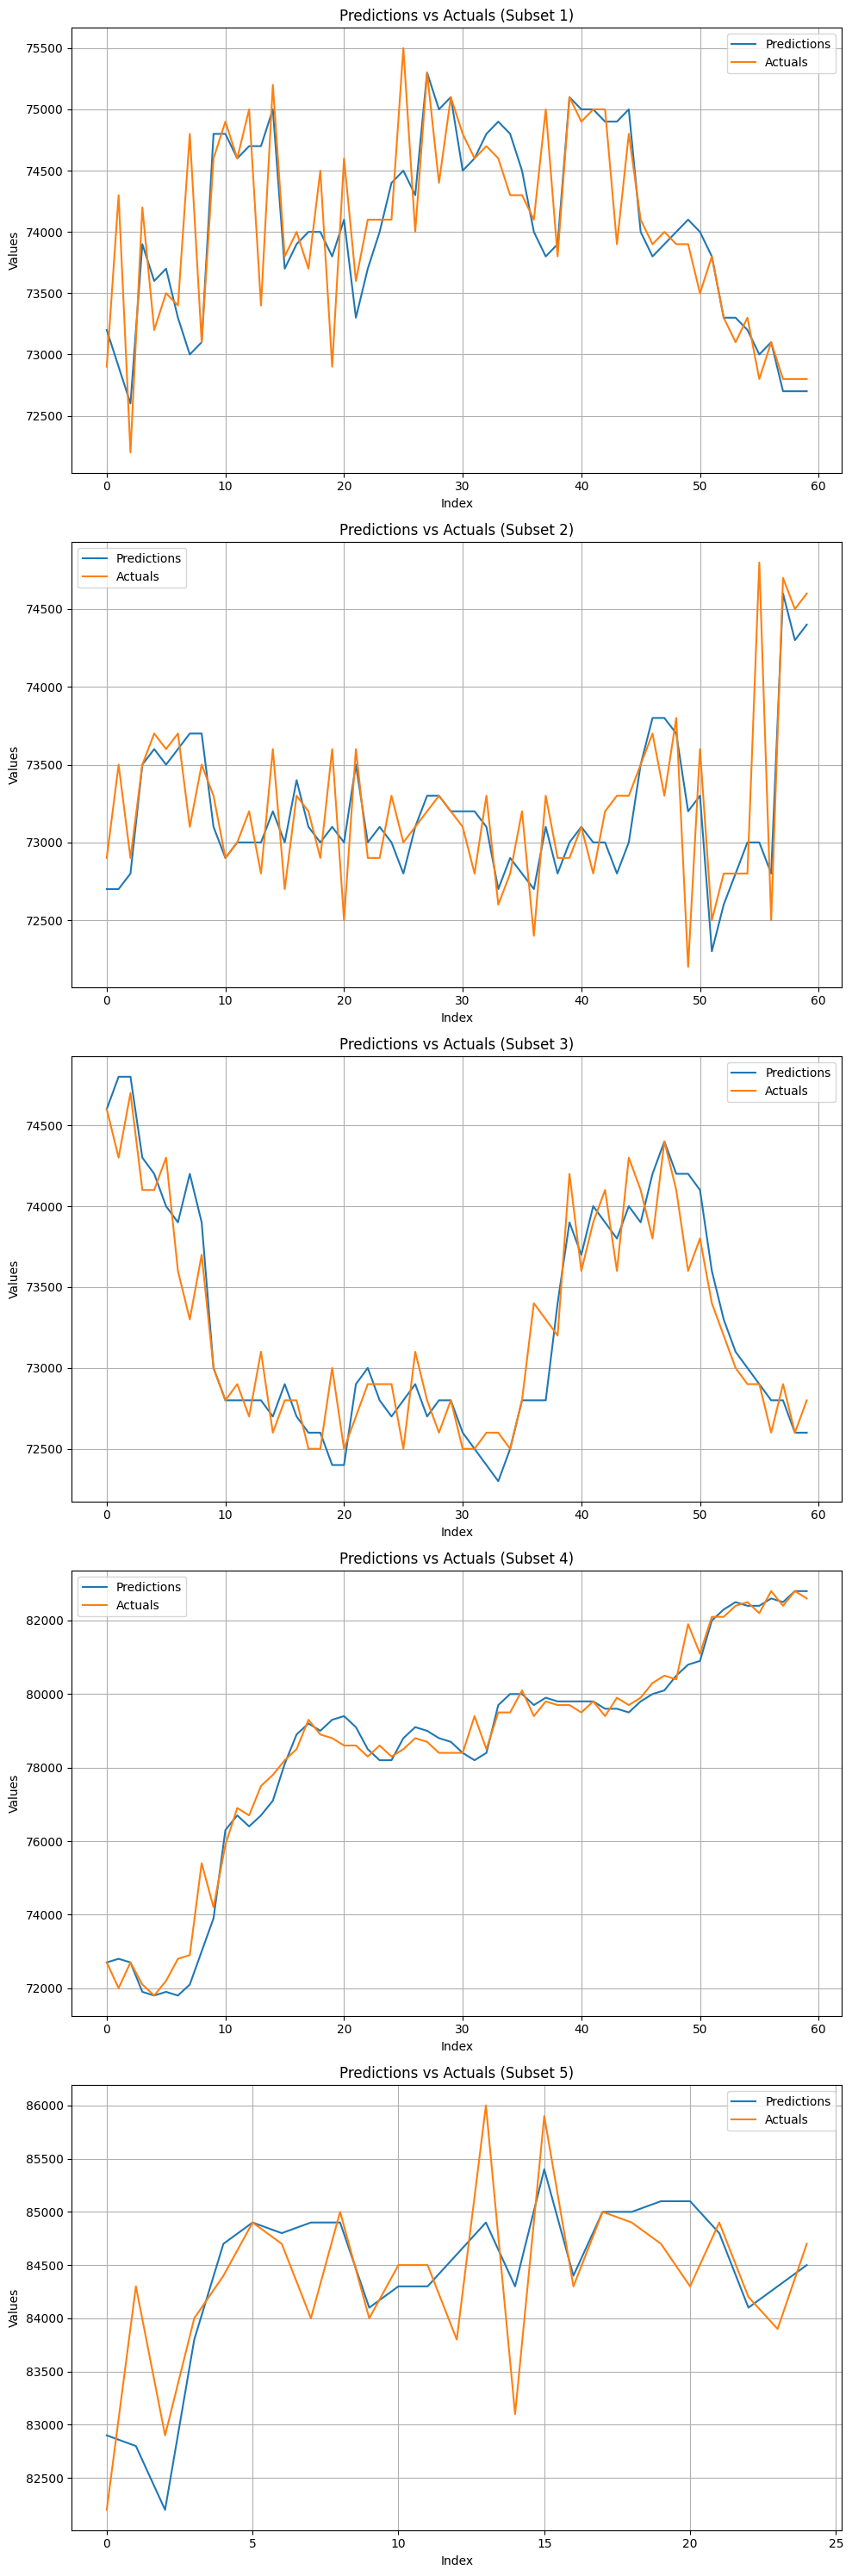

In [318]:
import matplotlib.pyplot as plt

# 전체 데이터를 4개로 나누기
n = 60
num_plots = len(predictions_inverse) // n
if len(predictions_inverse) % n != 0:
    num_plots += 1

# Plot 생성
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6*num_plots))

for i in range(num_plots):
    start_index = i * n
    end_index = min((i + 1) * n, len(predictions_inverse))
    
    # Subplot 생성
    ax = axes[i] if num_plots > 1 else axes
    
    # 예측값과 실제값 그리기
    ax.plot(predictions_inverse[start_index:end_index], label='Predictions')
    ax.plot(actuals_inverse[start_index:end_index], label='Actuals')
    ax.set_title(f'Predictions vs Actuals (Subset {i+1})')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()